In [158]:
import pandas as pd
import numpy as np

# Tạo dữ liệu ngẫu nhiên cho 1000 dòng và 3 cột
n = 1000
item_id = np.concatenate([
    np.random.choice(np.delete(np.arange(1, 54), [9, 13, 14, 15, 21, 23]), size=n)
])
# Tạo DataFrame từ dữ liệu
df = pd.DataFrame({
    'user_id': np.random.randint(1, 53, size=n),
    'item_id': item_id,
    'rating': np.random.randint(1, 6, size=n),
    'quantity_bought': np.random.randint(1, 50, size=n)  # Số lượng mua từ 1 đến 10
})


# In ra 5 dòng đầu tiên của DataFrame
print(df.head())
df.to_csv('newdata.csv', index=False)

   user_id  item_id  rating  quantity_bought
0       40       36       4               13
1       48        8       5               47
2       36       51       3               15
3        1       34       2               20
4       45        6       5                5


In [159]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

In [160]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  1000
No of columns =  4


Datatypes


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   user_id          1000 non-null   int64
 1   item_id          1000 non-null   int64
 2   rating           1000 non-null   int64
 3   quantity_bought  1000 non-null   int64
dtypes: int64(4)
memory usage: 31.4 KB


In [162]:
df.isna().sum()

user_id            0
item_id            0
rating             0
quantity_bought    0
dtype: int64

In [163]:
# Summary statistics of 'rating' variable
df['rating'].describe()

count    1000.000000
mean        2.994000
std         1.419147
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: rating, dtype: float64

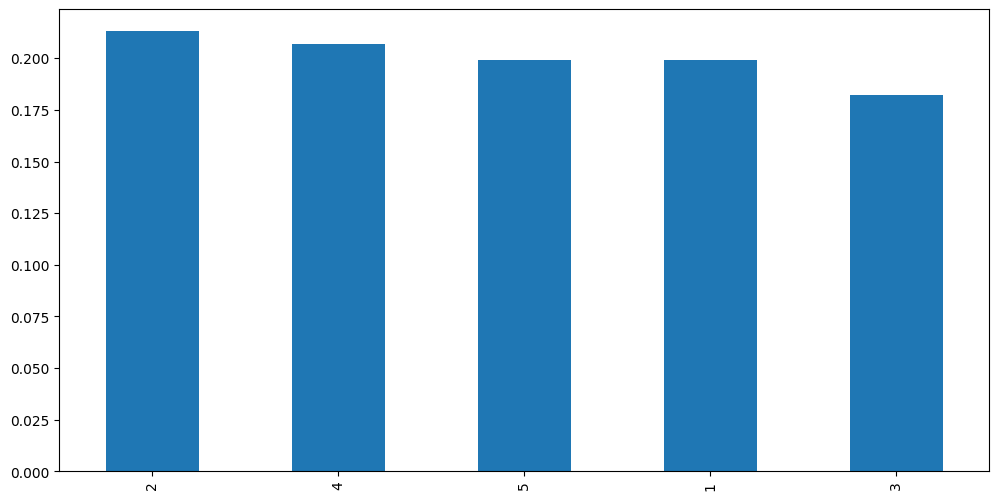

In [164]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

In [165]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['item_id'].nunique())

Number of unique USERS in Raw data =  52
Number of unique ITEMS in Raw data =  47


In [166]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated


user_id
7     34
4     30
44    27
36    26
6     25
8     25
14    25
38    24
50    23
20    23
dtype: int64

In [167]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 15].index)]

In [168]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['item_id'].nunique())

The number of observations in the final data = 916
Number of unique USERS in the final data =  45
Number of unique PRODUCTS in the final data =  47


In [169]:
df_unique = df_final.drop_duplicates(['user_id', 'item_id'])
print(df_unique)

     user_id  item_id  rating  quantity_bought
0         40       36       4               13
1         48        8       5               47
2         36       51       3               15
3          1       34       2               20
4         45        6       5                5
..       ...      ...     ...              ...
990        6       36       3               47
992       45       28       4                7
993       20       11       5               37
994       27       11       4               14
998       37       11       5               31

[751 rows x 4 columns]


In [170]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_unique.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (45, 47)
given_num_of_ratings =  751
possible_num_of_ratings =  2115
density: 35.51%


item_id,1,2,3,4,5,6,7,8,9,11,...,44,45,46,47,48,49,50,51,52,53
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0
4,1.0,5.0,5.0,0.0,2.0,1.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,2.0,5.0,0.0,5.0,0.0,0.0
6,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,4.0,4.0,0.0,5.0,0.0,0.0,3.0


In [171]:
#Calculate the average rating for each product
average_rating = df_unique.groupby('item_id').mean()['rating']

#Calculate the count of ratings for each product
count_rating = df_unique.groupby('item_id').count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)
final_rating.head()

,avg_rating,rating_count
item_id,,
49,3.714286,14
11,3.684211,19
47,3.666667,18
48,3.600000,15
50,3.500000,18


In [172]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)
    return recommendations.index[:n]

In [173]:
list(top_n_products(final_rating, 5, 5))

[49, 11, 47, 48, 50]

In [174]:
final_ratings_matrix.head()
# Xuất interactions_matrix thành file CSV
final_ratings_matrix.to_csv('interactions_matrix.csv', index=False)


In [175]:

final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,11,...,44,45,46,47,48,49,50,51,52,53
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0
3,1.0,5.0,5.0,0.0,2.0,1.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,2.0,5.0,0.0,5.0,0.0,0.0
4,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,4.0,4.0,0.0,5.0,0.0,0.0,3.0


In [176]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

In [177]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar


[8, 7, 21, 25, 10, 5, 16, 22, 28, 39]

In [178]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.52581311]]),
 array([[0.51862565]]),
 array([[0.5003952]]),
 array([[0.47908746]]),
 array([[0.47658751]]),
 array([[0.45771924]]),
 array([[0.4555433]]),
 array([[0.44453016]]),
 array([[0.43744116]]),
 array([[0.43686353]])]

In [179]:
similar = similar_users(44, final_ratings_matrix)[0][0:10]
similar

[24, 43, 38, 19, 23, 40, 22, 16, 31, 36]

In [181]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]


Model đã được lưu vào recommendation_model.pkl


In [201]:

from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
from recommendations import recommendations
final_ratings_matrix = pd.read_csv('interactions_matrix.csv')

# Kiểm tra dữ liệu đã được đọc chưa
app = Flask(__name__)
run_with_ngrok(app)  # Khởi động ngrok khi Flask app được khởi chạy

@app.route('/recommendations', methods=['POST'])
def get_recommendations():
    # Lấy các tham số từ yêu cầu
    user_index = request.args.get('user_index')
    num_of_products = request.args.get('num_of_products')
    # Gọi hàm recommendations và lấy kết quả
    recommended_products = recommendations(user_index, num_of_products, final_ratings_matrix)
    # Trả về kết quả dưới dạng JSON
    return jsonify(recommended_products)

if __name__ == '__main__':
    app.run(port=2000)

TypeError: run_with_ngrok.<locals>.new_run() got an unexpected keyword argument 'port'

In [203]:
from fastapi import FastAPI

app = FastAPI()

@app.post("/recommendations")
async def get_recommendations(user_index: int, num_of_products: int):
    # Đây là nơi bạn sẽ gọi hàm recommendations và trả về kết quả
    return {"user_index": user_index, "num_of_products": num_of_products}


In [208]:
!pip install fastapi nest-asyncio pyngrok uvicorn
!ngrok authtoken 2eMZ0npniwq5hyDlpFiIVJWKQLm_4qR7iDhJbohys6r44fgh3
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio
import uvicorn

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

@app.get('/')
async def root():
    return {'hello': 'world'}

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


INFO:     Started server process [334]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Public URL: https://0667-34-105-4-102.ngrok-free.app
INFO:     14.241.183.208:0 - "GET / HTTP/1.1" 200 OK
INFO:     14.241.183.208:0 - "GET / HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [334]


KeyboardInterrupt: 

ERROR:    Error loading ASGI app. Could not import module "your_module_name".


In [112]:
interactions_matrix = pd.read_csv('interactions_matrix.csv', )
interactions_matrix.head()

,1,2,3,4,5,6,7,8,9,11,...,44,45,46,47,48,49,50,51,52,53
0,5.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,4.0,2.0,0.0,0.0,0.0,4.0
1,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0
2,0.0,3.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,5.0,...,3.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,4.0,5.0
3,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,...,4.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
4,2.0,2.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,1.0,...,0.0,2.0,0.0,0.0,4.0,0.0,1.0,5.0,5.0,4.0


In [113]:
import pandas as pd
import joblib

# Đọc ma trận tương tác từ file CSV
interactions_matrix = pd.read_csv('interactions_matrix.csv')

# Load model từ file .pkl
file_name = 'recommendation_model.pkl'
model = joblib.load(file_name)

# Chạy mô hình với ma trận tương tác và người dùng index là 2, và số lượng sản phẩm gợi ý là 5
user_index = 2
num_of_products = 5

# Gợi ý sản phẩm cho người dùng
recommendations = model(user_index, num_of_products, interactions_matrix)

# In ra danh sách các sản phẩm được gợi ý
print("Các sản phẩm được gợi ý cho người dùng có index", user_index, ":")
for i, product_id in enumerate(recommendations, start=1):
    print(f"{i}. Product ID: {product_id}")


Các sản phẩm được gợi ý cho người dùng có index 2 :
1. Product ID: 45
2. Product ID: 32
3. Product ID: 41
4. Product ID: 46
5. Product ID: 19


In [129]:
recommendations(3,5,final_ratings_matrix)

[33, 3, 5, 40, 42]

In [130]:

from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)

In [132]:
# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 40) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [133]:
U.shape
sigma.shape
Vt.shape

(45, 40)

(40, 40)

(40, 47)

In [134]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

item_id,1,2,3,4,5,6,7,8,9,11,...,44,45,46,47,48,49,50,51,52,53
0,0.067613,3.879999,0.005569,2.113250,0.068222,0.974853,4.986685,2.050552,2.975375,0.033556,...,0.070773,3.935012,0.018546,0.060340,0.041008,0.029739,0.003897,0.118884,2.013403,0.084742
1,0.024413,0.151673,2.883958,0.066654,0.108524,0.104813,0.131185,0.117603,0.189304,0.085331,...,0.063118,0.839296,0.044854,0.079608,0.013529,0.006732,3.921924,1.187106,0.043671,1.058584
2,0.035039,0.081550,0.008586,0.031655,0.040254,0.028614,0.040868,5.039591,0.008226,0.013882,...,0.008617,0.065530,0.034555,0.970623,0.016440,1.004687,3.906693,0.043385,0.019213,4.943462
3,0.011530,0.037131,0.085280,0.060818,0.015785,3.001292,0.056890,0.012552,0.090118,2.993493,...,4.954428,0.098788,4.001099,2.046309,0.035890,3.065897,0.047274,0.080871,0.004783,1.945103
4,0.064754,0.025693,0.012231,4.947173,0.995774,4.105174,0.886948,0.004438,0.083933,0.002099,...,5.005962,3.022610,0.007889,0.079289,0.047570,5.016457,0.055510,0.071961,0.036353,0.099677


In [135]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))

In [136]:

#Enter 'user index' and 'num_recommendations' for the user
recommend_items(22,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 22):

Recommended Products
32    0.137011
1     0.126082
23    0.082662
12    0.071377
13    0.068025
Name: user_predictions, dtype: float64


In [137]:
recommend_items(2,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 2):

Recommended Products
32    0.103550
20    0.086459
1     0.081550
12    0.079113
16    0.077071
33    0.076028
10    0.067677
38    0.065530
17    0.061901
29    0.051037
Name: user_predictions, dtype: float64


In [138]:

final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,11,...,44,45,46,47,48,49,50,51,52,53
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,4.0,0.0,2.0,0.0,1.0,5.0,2.0,3.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,5.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,...,5.0,0.0,4.0,2.0,0.0,3.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,5.0,1.0,4.0,1.0,0.0,0.0,0.0,...,5.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0


In [139]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

item_id
1    1.355556
2    0.711111
3    0.822222
4    1.222222
5    1.466667
dtype: float64

In [140]:
preds_df.head()

item_id,1,2,3,4,5,6,7,8,9,11,...,44,45,46,47,48,49,50,51,52,53
0,0.067613,3.879999,0.005569,2.113250,0.068222,0.974853,4.986685,2.050552,2.975375,0.033556,...,0.070773,3.935012,0.018546,0.060340,0.041008,0.029739,0.003897,0.118884,2.013403,0.084742
1,0.024413,0.151673,2.883958,0.066654,0.108524,0.104813,0.131185,0.117603,0.189304,0.085331,...,0.063118,0.839296,0.044854,0.079608,0.013529,0.006732,3.921924,1.187106,0.043671,1.058584
2,0.035039,0.081550,0.008586,0.031655,0.040254,0.028614,0.040868,5.039591,0.008226,0.013882,...,0.008617,0.065530,0.034555,0.970623,0.016440,1.004687,3.906693,0.043385,0.019213,4.943462
3,0.011530,0.037131,0.085280,0.060818,0.015785,3.001292,0.056890,0.012552,0.090118,2.993493,...,4.954428,0.098788,4.001099,2.046309,0.035890,3.065897,0.047274,0.080871,0.004783,1.945103
4,0.064754,0.025693,0.012231,4.947173,0.995774,4.105174,0.886948,0.004438,0.083933,0.002099,...,5.005962,3.022610,0.007889,0.079289,0.047570,5.016457,0.055510,0.071961,0.036353,0.099677


In [141]:

avg_preds=preds_df.mean()
avg_preds.head()

item_id
1    1.385584
2    0.777784
3    0.852510
4    1.266347
5    1.489592
dtype: float64

In [142]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
item_id,,
1,1.355556,1.385584
2,0.711111,0.777784
3,0.822222,0.852510
4,1.222222,1.266347
5,1.466667,1.489592


In [143]:

RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.040897286456706795 

